In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

In [2]:
raw_data = pd.read_csv('all_data_raw.csv',index_col=0)
raw_data

,简称,日期,开盘价(元),收盘价(元),subsector
代码,,,,,
600030.SH,中信证券,2010-01-04,16.50,16.13,资本市场服务
600030.SH,中信证券,2010-01-05,16.26,16.92,资本市场服务
600030.SH,中信证券,2010-01-06,17.01,16.72,资本市场服务
600030.SH,中信证券,2010-01-07,16.71,16.32,资本市场服务
600030.SH,中信证券,2010-01-08,16.21,16.63,资本市场服务
...,...,...,...,...,...
000563.SZ,陕国投A,2021-01-13,3.59,3.51,其他金融业
000563.SZ,陕国投A,2021-01-14,3.49,3.51,其他金融业
000563.SZ,陕国投A,2021-01-15,3.51,3.52,其他金融业


In [3]:
raw_data['month'] = raw_data.apply(lambda x:x['日期'][:-3],axis=1)
raw_data['year'] = raw_data.apply(lambda x:x['日期'][:-6],axis=1)

In [4]:
raw_data['return'] = np.log(raw_data['收盘价(元)'])-np.log(raw_data['开盘价(元)'])

In [5]:
raw_data

,简称,日期,开盘价(元),收盘价(元),subsector,month,year,return
代码,,,,,,,,
600030.SH,中信证券,2010-01-04,16.50,16.13,资本市场服务,2010-01,2010,-0.022679
600030.SH,中信证券,2010-01-05,16.26,16.92,资本市场服务,2010-01,2010,0.039788
600030.SH,中信证券,2010-01-06,17.01,16.72,资本市场服务,2010-01,2010,-0.017196
600030.SH,中信证券,2010-01-07,16.71,16.32,资本市场服务,2010-01,2010,-0.023616
600030.SH,中信证券,2010-01-08,16.21,16.63,资本市场服务,2010-01,2010,0.025580
...,...,...,...,...,...,...,...,...
000563.SZ,陕国投A,2021-01-13,3.59,3.51,其他金融业,2021-01,2021,-0.022536
000563.SZ,陕国投A,2021-01-14,3.49,3.51,其他金融业,2021-01,2021,0.005714
000563.SZ,陕国投A,2021-01-15,3.51,3.52,其他金融业,2021-01,2021,0.002845


In [6]:
mutiIndex = list(zip(raw_data['month'],raw_data['简称']))
index = pd.MultiIndex.from_tuples(mutiIndex,names=['month','简称'])
raw_data.set_index(index)

简称          日期  开盘价(元)  收盘价(元) subsector    month  year  \
month   简称                                                                
2010-01 中信证券  中信证券  2010-01-04   16.50   16.13    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-05   16.26   16.92    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-06   17.01   16.72    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-07   16.71   16.32    资本市场服务  2010-01  2010   
        中信证券  中信证券  2010-01-08   16.21   16.63    资本市场服务  2010-01  2010   
...            ...         ...     ...     ...       ...      ...   ...   
2021-01 陕国投A  陕国投A  2021-01-13    3.59    3.51     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-14    3.49    3.51     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-15    3.51    3.52     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-18    3.50    3.54     其他金融业  2021-01  2021   
        陕国投A  陕国投A  2021-01-19    3.53    3.60     其他金融业  2021-01  2021   

                return  
month   简称              
2010-01 中信证券 -0.022679  
        中信证券  0.039788  
        中信证券 -0.017196  
        中信证券 -0.023616  
        中信证券  0.025580  
...                ...  
2021-01 陕国投A -0.022536  
        陕国投A  0.005714  
        陕国投A  0.002845  
        陕国投A  0.011364  
        陕国投A  0.019636  

[230203 rows x 8 columns]

In [10]:
one_month = raw_data[raw_data['month']=='2020-01']
one_month[one_month['简称']=='中信证券']

,简称,日期,开盘价(元),收盘价(元),subsector,month,year,return
代码,,,,,,,,
600030.SH,中信证券,2020-01-02,25.34,25.09,资本市场服务,2020-01,2020,-0.009915
600030.SH,中信证券,2020-01-03,24.94,24.98,资本市场服务,2020-01,2020,0.001603
600030.SH,中信证券,2020-01-06,24.67,24.92,资本市场服务,2020-01,2020,0.010083
600030.SH,中信证券,2020-01-07,25.00,25.30,资本市场服务,2020-01,2020,0.011929
600030.SH,中信证券,2020-01-08,25.03,24.55,资本市场服务,2020-01,2020,-0.019363
600030.SH,中信证券,2020-01-09,24.93,25.04,资本市场服务,2020-01,2020,0.004403
600030.SH,中信证券,2020-01-10,25.55,25.15,资本市场服务,2020-01,2020,-0.015779
600030.SH,中信证券,2020-01-13,25.05,25.56,资本市场服务,2020-01,2020,0.020155
600030.SH,中信证券,2020-01-14,25.57,25.16,资本市场服务,2020-01,2020,-0.016164


In [46]:
pivot_m = pd.pivot_table(data=one_month,values='return',columns='简称',index='日期')
pivot_m

简称,*ST安信,*ST熊猫,上海银行,东兴证券,东北证券,东吴证券,东方能源,东方证券,东方财富,中信建投,...,邮储银行,郑州银行,锦龙股份,长城证券,长江证券,长沙银行,陕国投A,青农商行,青岛银行,鲁信创投
日期,,,,,,,,,,,,,,,,,,,,,
2020-01-02,-0.017778,0.078172,-0.003277,-0.019878,-0.024853,-0.025725,0.005343,-0.001866,-0.012777,0.001930,...,0.005286,-0.002407,-0.019725,-0.022295,-0.014165,-0.005679,-0.020248,-0.028348,-0.015558,0.006809
2020-01-03,0.024527,-0.048705,-0.005479,-0.009324,-0.004391,-0.001093,-0.001784,-0.000939,0.006785,0.002269,...,0.008749,-0.004831,-0.006010,0.010167,-0.005747,0.000000,0.011377,-0.008084,0.001753,-0.010702
2020-01-06,-0.002250,0.018725,-0.002210,0.007893,0.013275,0.004420,0.012467,0.010432,0.018032,0.019725,...,-0.005277,0.004854,0.037967,0.001459,0.011561,0.000000,0.006810,-0.003284,0.003521,0.014185
2020-01-07,0.002245,-0.004415,0.003306,0.012471,0.002191,0.006550,0.007030,-0.000940,-0.000745,0.028180,...,0.005296,0.007255,-0.001963,0.007023,0.001428,0.005705,0.006734,0.009788,0.005259,0.050842
2020-01-08,-0.025318,-0.014454,-0.011099,-0.027072,-0.022372,-0.025628,-0.028320,-0.028932,-0.028214,-0.020196,...,-0.005333,-0.012151,-0.032768,-0.017417,-0.026317,-0.017272,-0.027525,-0.018137,-0.019487,-0.019714
2020-01-09,-0.002301,0.006315,-0.002225,-0.007949,0.000000,-0.007773,0.003571,0.001932,0.007536,-0.012258,...,0.003559,-0.002436,-0.006026,-0.003598,0.001455,0.001153,0.002291,-0.001654,0.000000,-0.009485
2020-01-10,-0.016111,-0.019065,0.000000,-0.008013,-0.018837,-0.015713,-0.014363,-0.008559,-0.011870,-0.015623,...,0.008873,0.000000,-0.029453,-0.022392,-0.016784,-0.003450,-0.011403,-0.003306,-0.003546,-0.021629
2020-01-13,0.023149,0.000916,-0.001128,0.034090,0.023296,0.016921,-0.003636,0.023754,0.022523,0.018156,...,-0.012511,0.007326,0.018868,0.013206,0.015526,0.005744,0.011455,0.008244,0.000000,0.000642
2020-01-14,-0.023096,-0.015518,-0.006795,-0.018089,-0.015453,-0.013499,0.007286,-0.012305,-0.021732,-0.026830,...,-0.005410,-0.002436,-0.003346,-0.015447,-0.015570,-0.003434,-0.004577,-0.013158,-0.005352,0.001280


In [47]:
corr=pivot_m.corr()
corr

简称,*ST安信,*ST熊猫,上海银行,东兴证券,东北证券,东吴证券,东方能源,东方证券,东方财富,中信建投,...,邮储银行,郑州银行,锦龙股份,长城证券,长江证券,长沙银行,陕国投A,青农商行,青岛银行,鲁信创投
简称,,,,,,,,,,,,,,,,,,,,,
*ST安信,1.000000,-0.226082,0.177075,0.599400,0.627004,0.499514,0.344557,0.598688,0.700783,0.586830,...,0.331144,0.504021,0.440420,0.644963,0.561883,0.501184,0.643481,0.577813,0.520031,0.295162
*ST熊猫,-0.226082,1.000000,0.395544,0.182151,0.177108,0.168946,0.449556,0.401323,0.231760,0.058015,...,0.076088,0.317558,0.306371,-0.045461,0.308044,0.296875,0.048605,-0.118064,-0.034507,0.427289
上海银行,0.177075,0.395544,1.000000,0.715374,0.671432,0.801011,0.435565,0.747793,0.685022,0.403175,...,0.244888,0.654191,0.603814,0.622602,0.709828,0.785301,0.747610,0.650614,0.766462,0.622871
东兴证券,0.599400,0.182151,0.715374,1.000000,0.928523,0.910479,0.344724,0.896772,0.872381,0.594922,...,0.015589,0.711945,0.799008,0.772973,0.922557,0.739986,0.805441,0.853979,0.767880,0.570439
东北证券,0.627004,0.177108,0.671432,0.928523,1.000000,0.940504,0.478051,0.914144,0.937763,0.600419,...,0.072769,0.672353,0.908285,0.842430,0.940116,0.751612,0.896722,0.810047,0.773392,0.550719
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
长沙银行,0.501184,0.296875,0.785301,0.739986,0.751612,0.768204,0.713888,0.802868,0.762792,0.251775,...,0.236077,0.833707,0.672539,0.556061,0.773613,1.000000,0.850709,0.733401,0.765897,0.713653
陕国投A,0.643481,0.048605,0.747610,0.805441,0.896722,0.908804,0.598807,0.850484,0.883695,0.535493,...,0.253229,0.695800,0.834168,0.840818,0.839174,0.850709,1.000000,0.764236,0.881034,0.584696
青农商行,0.577813,-0.118064,0.650614,0.853979,0.810047,0.787892,0.300374,0.701971,0.771333,0.492683,...,0.146420,0.682937,0.585961,0.718538,0.792155,0.733401,0.764236,1.000000,0.834264,0.555650


In [48]:
print(sum(np.sum(corr.isna())))

0


In [49]:
distance_m = np.sqrt(2*(1-corr))
distance_m

简称,*ST安信,*ST熊猫,上海银行,东兴证券,东北证券,东吴证券,东方能源,东方证券,东方财富,中信建投,...,邮储银行,郑州银行,锦龙股份,长城证券,长江证券,长沙银行,陕国投A,青农商行,青岛银行,鲁信创投
简称,,,,,,,,,,,,,,,,,,,,,
*ST安信,0.000000,1.565938,1.282907,0.895098,0.863709,1.000486,1.144939,0.895893,0.773585,0.909033,...,1.156595,0.995971,1.057903,0.842659,0.936074,0.998815,0.844415,0.918898,0.979764,1.187298
*ST熊猫,1.565938,0.000000,1.099505,1.278944,1.282881,1.289228,1.049233,1.094237,1.239549,1.372578,...,1.359347,1.168283,1.177820,1.446002,1.176398,1.185854,1.379416,1.495369,1.438407,1.070244
上海银行,1.282907,1.099505,0.000000,0.754487,0.810640,0.630855,1.062483,0.710221,0.793697,1.092543,...,1.228912,0.831636,0.890153,0.868790,0.761803,0.655285,0.710479,0.835926,0.683430,0.868480
东兴证券,0.895098,1.278944,0.754487,0.000000,0.378094,0.423133,1.144794,0.454374,0.505211,0.900087,...,1.403147,0.759019,0.634022,0.673835,0.393556,0.721130,0.623793,0.540409,0.681352,0.926888
东北证券,0.863709,1.282881,0.810640,0.378094,0.000000,0.344953,1.021714,0.414381,0.352808,0.893958,...,1.361786,0.809502,0.428287,0.561373,0.346075,0.704823,0.454485,0.616366,0.673214,0.947926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
长沙银行,0.998815,1.185854,0.655285,0.721130,0.704823,0.680876,0.756455,0.627904,0.688778,1.223295,...,1.236061,0.576702,0.809273,0.942272,0.672885,0.000000,0.546426,0.730204,0.684255,0.756765
陕国投A,0.844415,1.379416,0.710479,0.623793,0.454485,0.427074,0.895760,0.546838,0.482296,0.963854,...,1.222105,0.780000,0.575903,0.564238,0.567144,0.546426,0.000000,0.686679,0.487784,0.911377
青农商行,0.918898,1.495369,0.835926,0.540409,0.616366,0.651319,1.182900,0.772047,0.676265,1.007291,...,1.306583,0.796321,0.909988,0.750283,0.644740,0.730204,0.686679,0.000000,0.575736,0.942709


In [50]:
import networkx as nx

In [51]:
zipped = []
for i in range(len(distance_m.columns)):
    zipped.append(list(zip([distance_m.columns[i]]*distance_m.shape[0],distance_m.index,distance_m[distance_m.columns[i]])))
List_flat = []
for i in zipped:
    for j in i:
        List_flat.append(j)
s_List_flat = list(set(List_flat))
G = nx.Graph()
for i in range(len(distance_m.columns)):
    G.add_node(distance_m.columns[i])
G.add_weighted_edges_from(s_List_flat)

In [52]:
mst = nx.minimum_spanning_tree(G=G)

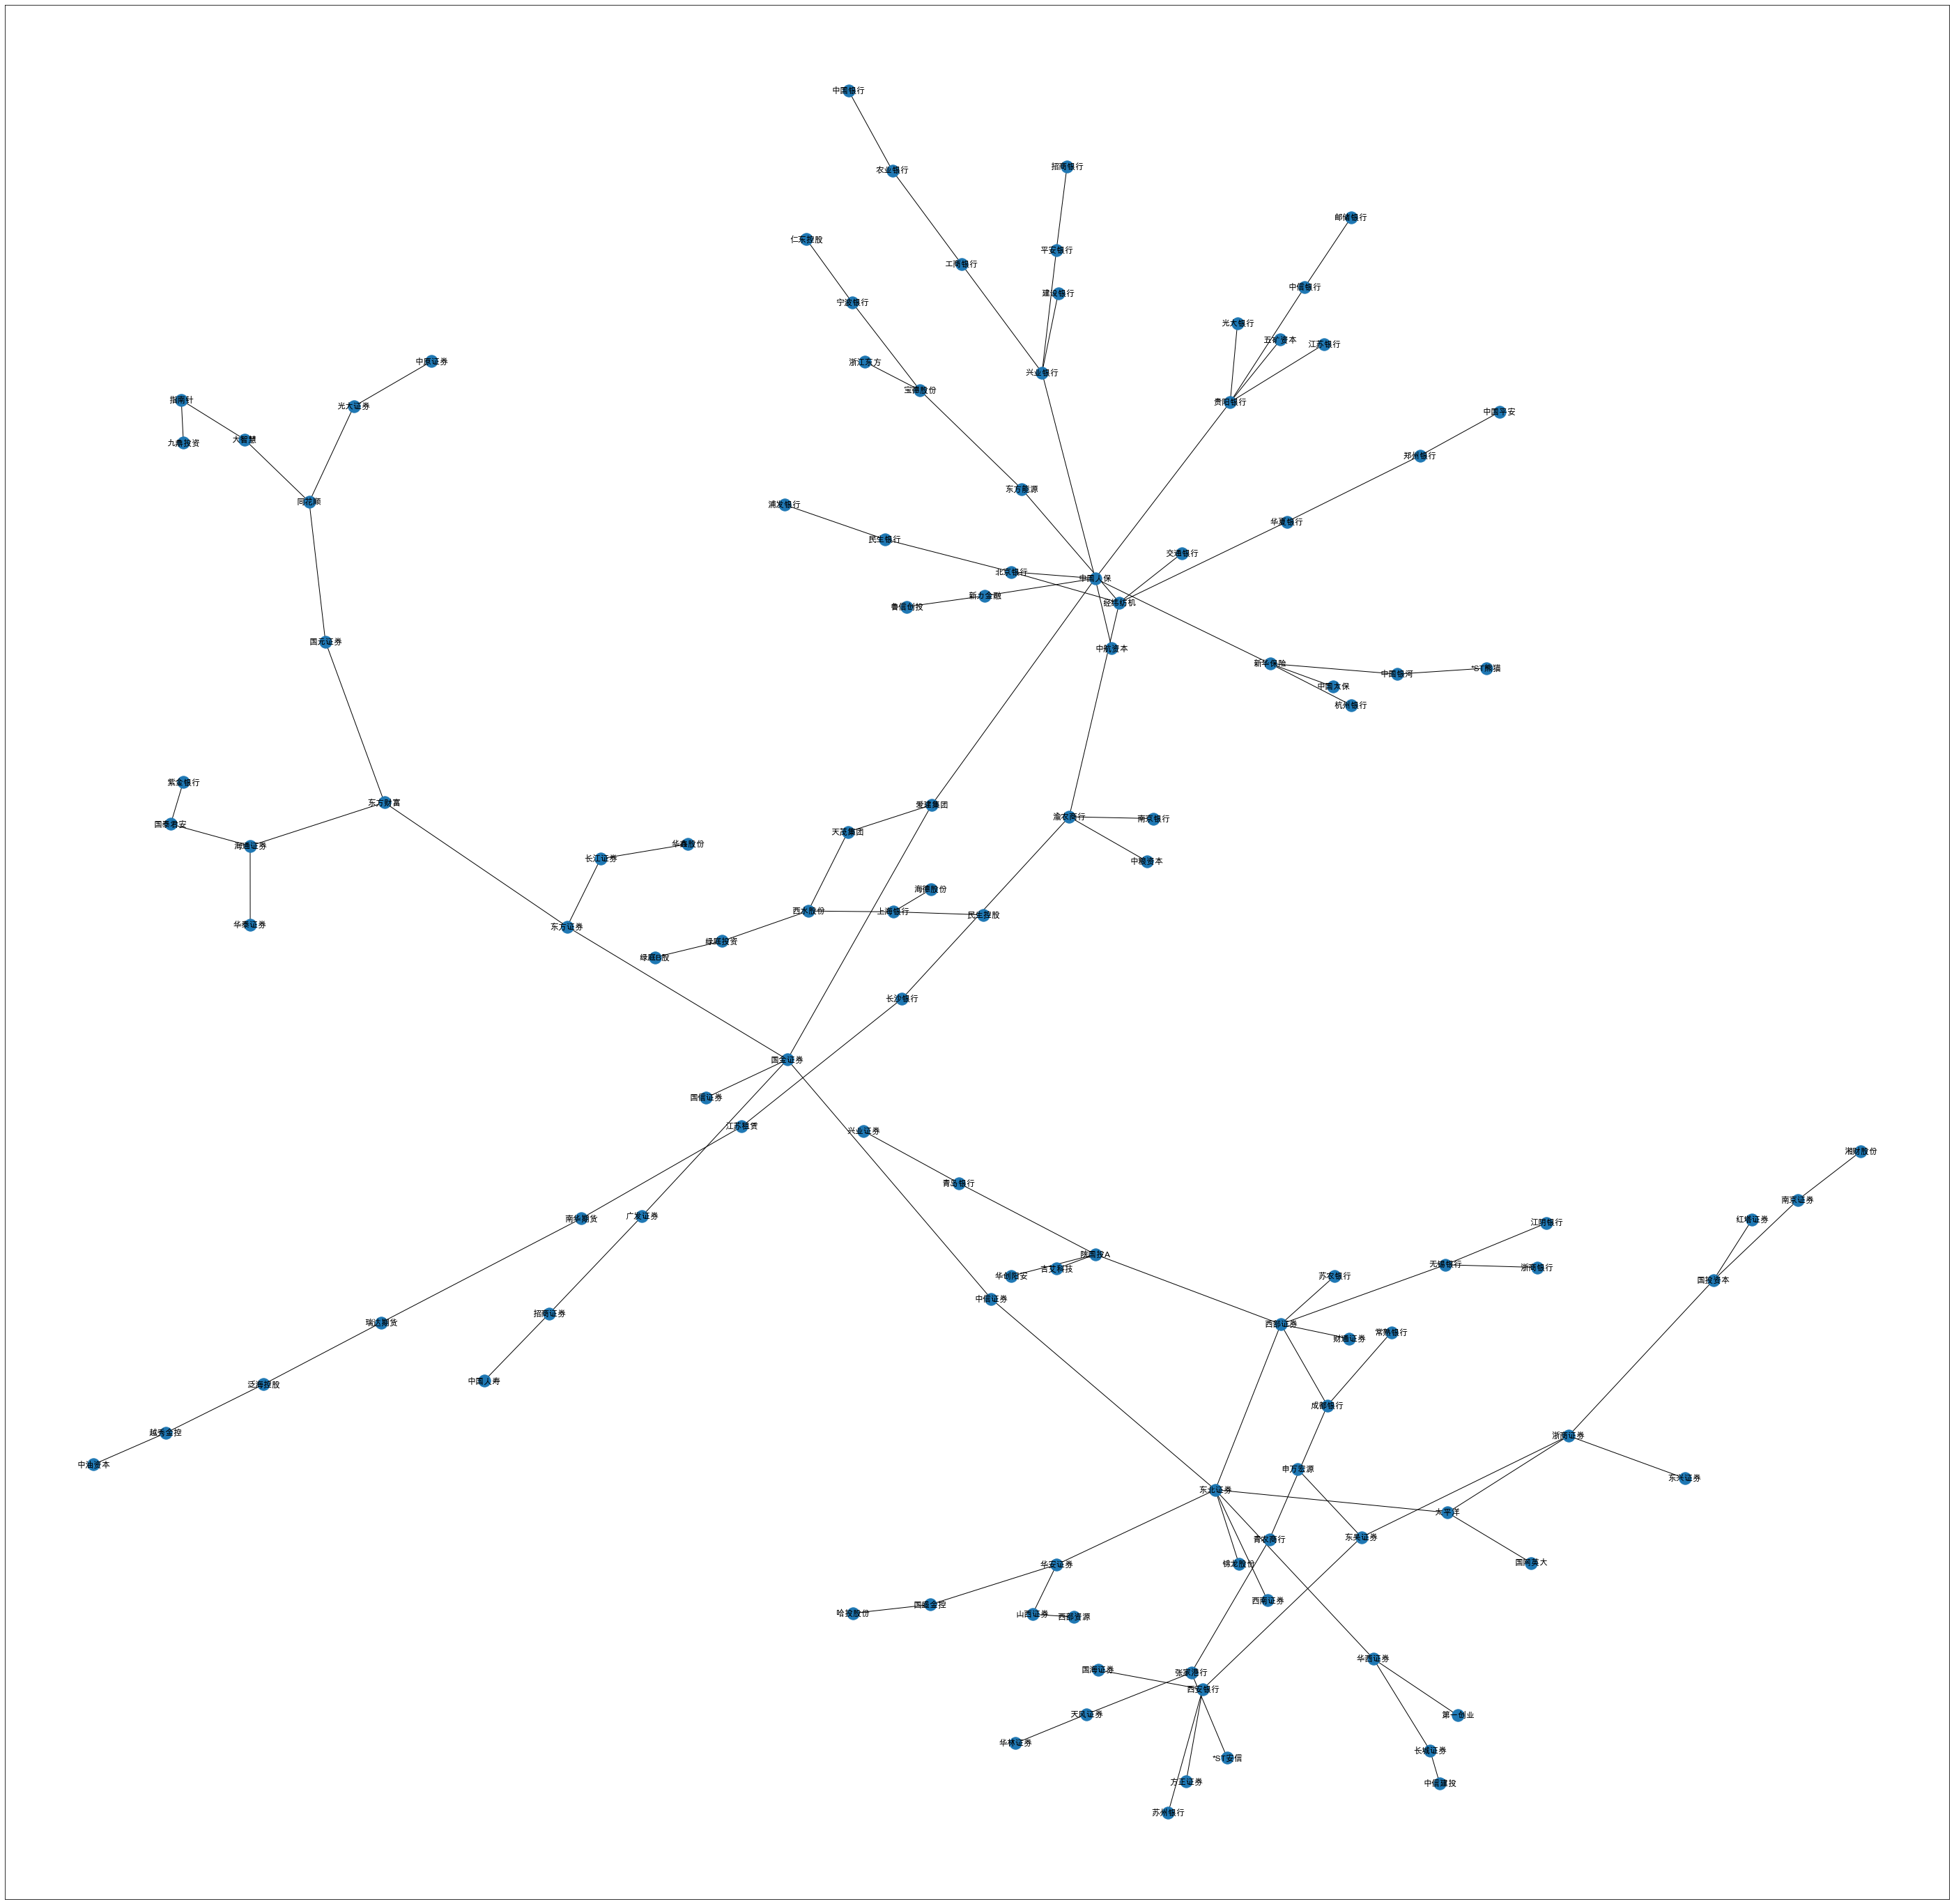

In [54]:
plt.figure(figsize=(50,50))

plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
nx.draw_networkx(mst,with_labels=True,)

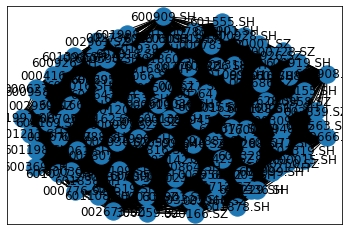

In [40]:
nx.draw_networkx(G,with_labels=True)

In [44]:
print(mst.degree)

[('000001.SZ', 2), ('000046.SZ', 2), ('000166.SZ', 1), ('000416.SZ', 1), ('000563.SZ', 4), ('000567.SZ', 1), ('000617.SZ', 1), ('000627.SZ', 2), ('000666.SZ', 5), ('000686.SZ', 7), ('000712.SZ', 1), ('000728.SZ', 2), ('000750.SZ', 1), ('000776.SZ', 2), ('000783.SZ', 2), ('000958.SZ', 2), ('000987.SZ', 2), ('002142.SZ', 2), ('002423.SZ', 1), ('002500.SZ', 2), ('002647.SZ', 1), ('002670.SZ', 2), ('002673.SZ', 6), ('002736.SZ', 1), ('002797.SZ', 1), ('002807.SZ', 1), ('002839.SZ', 3), ('002926.SZ', 3), ('002936.SZ', 2), ('002939.SZ', 2), ('002945.SZ', 1), ('002948.SZ', 2), ('002958.SZ', 2), ('002961.SZ', 2), ('002966.SZ', 1), ('300023.SZ', 3), ('300033.SZ', 3), ('300059.SZ', 3), ('300309.SZ', 1), ('300803.SZ', 2), ('600000.SH', 1), ('600015.SH', 2), ('600016.SH', 2), ('600030.SH', 2), ('600036.SH', 1), ('600053.SH', 1), ('600061.SH', 3), ('600095.SH', 1), ('600109.SH', 5), ('600120.SH', 1), ('600139.SH', 1), ('600155.SH', 1), ('600291.SH', 3), ('600318.SH', 2), ('600369.SH', 1), ('600390.